In [35]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf




warnings.filterwarnings("ignore") 

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
data = pd.ExcelFile(r"c:\Users\angel\OneDrive\Desktop\Datasets\procurement.xlsx")
conn = sqlite3.connect("output_database.db")

df = data.parse
sheetnames = data.sheet_names
print(sheetnames)

['MCRLMasterCrossReferenceList', 'MLCManagementdata', 'ProcurementHistory', 'ProcurementHistoryArchive', 'SRVADLAForecast', 'SRVA DLA Forecast Disclaimer', 'GovernmentSolicitations', 'Batch799208Details']


In [36]:
for sheet in data.sheet_names:
    df = data.parse(sheet)
    df.to_sql(sheet, conn, if_exists='replace', index=False)
    print(f"Sheet '{sheet}' in database")

#Checking to see if the sql database is established
df_query = pd.read_sql_query("SELECT * FROM 'MCRLMasterCrossReferenceList'", conn)
print(df_query.head())


Sheet 'MCRLMasterCrossReferenceList' in database
Sheet 'MLCManagementdata' in database
Sheet 'ProcurementHistory' in database
Sheet 'ProcurementHistoryArchive' in database
Sheet 'SRVADLAForecast' in database
Sheet 'SRVA DLA Forecast Disclaimer' in database
Sheet 'GovernmentSolicitations' in database
Sheet 'Batch799208Details' in database
    NIIN   CAGE                   Item_Name     Part_Number
0  30238  84685  ORIFICE,HYDRAULIC NAMIFOLD      HP848150-1
1  35273  70236    RING,EXTERNALLY THREADED      HP898406-1
2  43474  16603                     PACKING  E300-383-13-41
3  53557  57817           PACKING,PREFORMED        S1013-12
4  57148  70236      VALVE,RESTRICTOR CHECK     1164-1B3532


In [37]:
for sheet in data.sheet_names:
    print(f"missing values in sheet: {sheet}")
    df = data.parse(sheet)   
    missing_summary = df.isnull().sum()
    print(f"Missing values summary for {sheet}:\n{missing_summary}")

missing values in sheet: MCRLMasterCrossReferenceList
Missing values summary for MCRLMasterCrossReferenceList:
NIIN            0
CAGE            0
Item_Name      23
Part_Number     0
dtype: int64
missing values in sheet: MLCManagementdata
Missing values summary for MLCManagementdata:
NIIN          0
Unit_Price    0
dtype: int64
missing values in sheet: ProcurementHistory
Missing values summary for ProcurementHistory:
NIIN           0
Date           0
Price          0
Quantity       0
Total_Price    0
dtype: int64
missing values in sheet: ProcurementHistoryArchive
Missing values summary for ProcurementHistoryArchive:
NIIN           0
Date           0
Price          0
Quantity       0
Total_Price    0
dtype: int64
missing values in sheet: SRVADLAForecast
Missing values summary for SRVADLAForecast:
NIIN                 0
Supply_Chain         0
Item_Description     0
Latest_MLC_Price    12
Nov24                0
Dec24                0
Jan25                0
Feb25                0
Mar25    

In [38]:
#Cleaning MCRLMasterSheet
MCRL = "MCRLMasterCrossReferenceList"
MCRLdata = data.parse(MCRL)
MCRLdata_cleaned = MCRLdata.dropna()
MCRLdata_cleaned.to_sql(MCRL, conn, if_exists='replace', index=False)

#Cleaning Government Solicitations
govsol = "GovernmentSolicitations"
govsoldata = data.parse(govsol)
govsoldata_cleaned = govsoldata.dropna()
govsoldata_cleaned.to_sql(govsol, conn, if_exists='replace', index=False)

#Cleaning SRVADLAForecast
SRVADdata = data.parse("SRVADLAForecast")
SRVADdata_cleaned = SRVADdata.dropna()
SRVADdata_cleaned.to_sql("SRVADLAForecast", conn, if_exists='replace', index=False)

519

In [39]:
#Checking for missing values after cleaning
tables = ["MCRLMasterCrossReferenceList", "GovernmentSolicitations", "SRVADLAForecast"]
for table in tables:
    print(f"Checking for missing values in table: {table}")
    df_query = pd.read_sql_query(f"SELECT * FROM '{table}'", conn)
    # Check for missing values
    missing_summary = df_query.isnull().sum()
    total_missing = missing_summary.sum()
    if total_missing > 0:
        print(f"Table '{table}' contains missing values:\n{missing_summary}\n")
    else:
        print(f"Table '{table}' has no missing values.\n")
        


Checking for missing values in table: MCRLMasterCrossReferenceList
Table 'MCRLMasterCrossReferenceList' has no missing values.

Checking for missing values in table: GovernmentSolicitations
Table 'GovernmentSolicitations' has no missing values.

Checking for missing values in table: SRVADLAForecast
Table 'SRVADLAForecast' has no missing values.



In [40]:
print(df.columns)

Index(['BatchId', 'BatchLine', 'Searchkey', 'OrigKey', 'searchkey2',
       'Searchkey3', 'Searchkey4', 'Clin'],
      dtype='object')


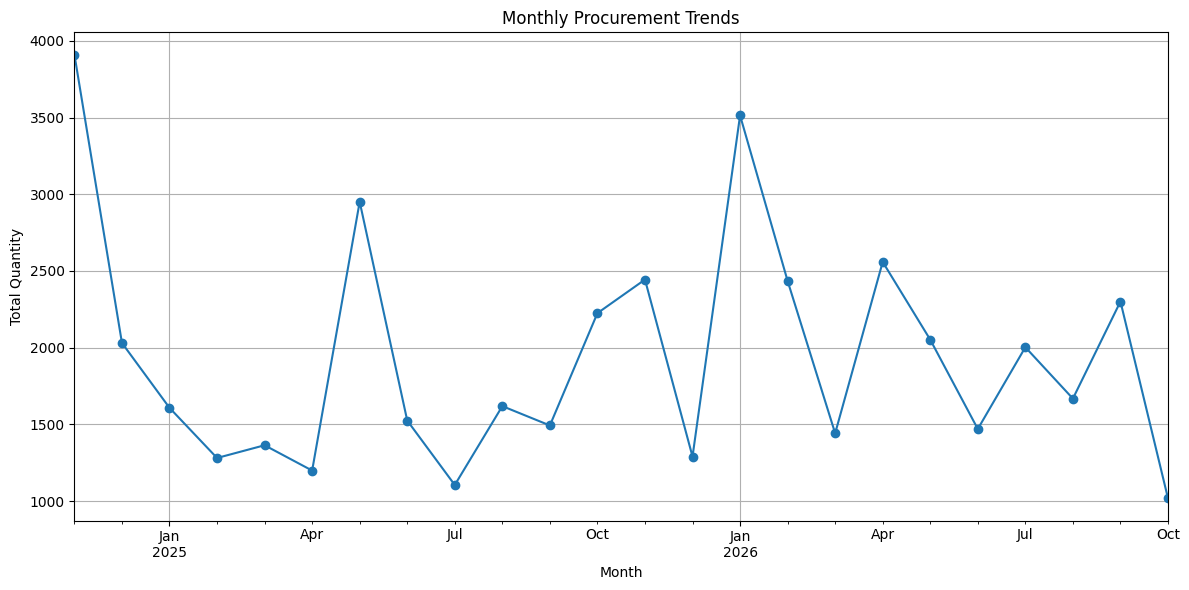

In [41]:

#Analyze procurement trends by month
melted_df = SRVADdata_cleaned.melt(id_vars=['NIIN', 'Supply_Chain', 'Item_Description', 'Latest_MLC_Price'], var_name='Date', value_name='Quantity')
melted_df = melted_df[melted_df['Date'] != 'Total']
melted_df['Date'] = melted_df['Date'].apply(lambda x: datetime.strptime(x, '%b%y'))
melted_df = melted_df.dropna(subset=['Quantity'])
melted_df['Quantity'] = pd.to_numeric(melted_df['Quantity'], errors='coerce')
monthly_data = melted_df.groupby(melted_df['Date'].dt.to_period('M'))['Quantity'].sum()

monthly_data = monthly_data.to_timestamp()

#Plotting Trend
plt.figure(figsize=(12, 6))
monthly_data.plot(kind='line', marker='o')
plt.title("Monthly Procurement Trends")
plt.xlabel("Month")
plt.ylabel("Total Quantity")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

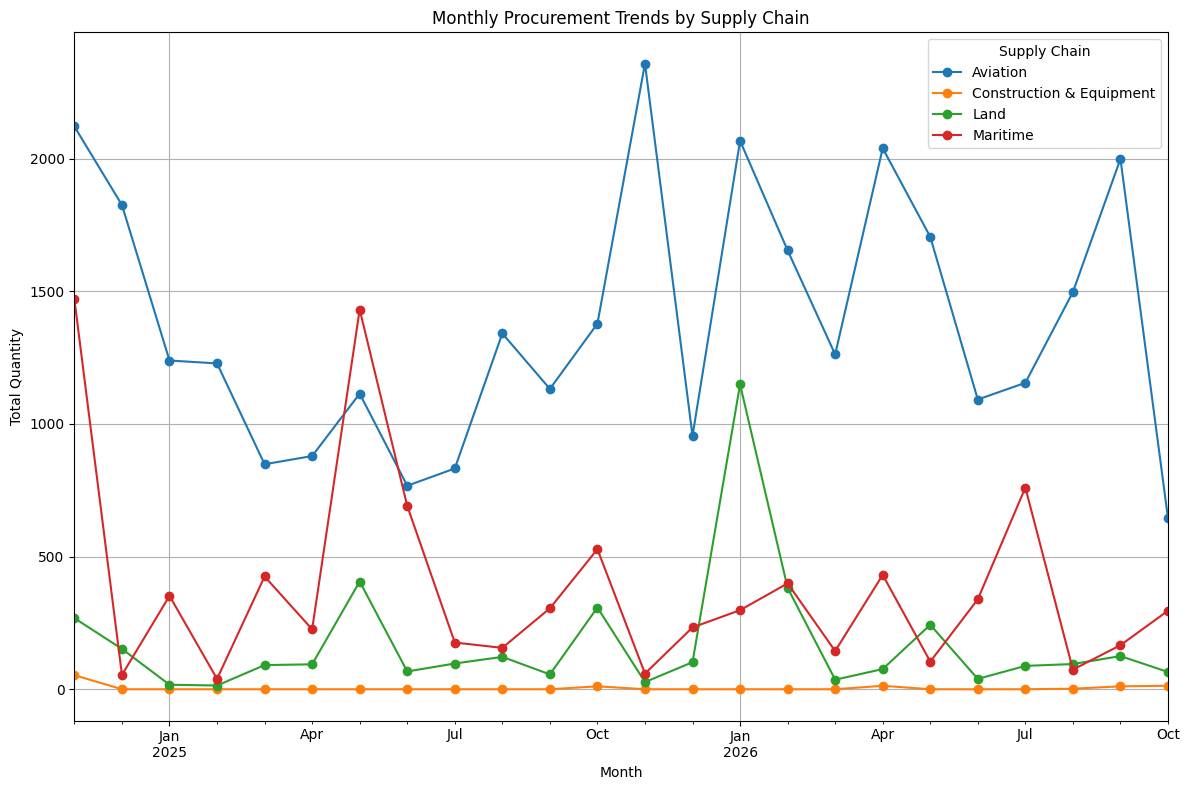

In [42]:
#Aggregate data by Supply Chain and Month
supply_chain_data = melted_df.groupby(['Supply_Chain', melted_df['Date'].dt.to_period('M')])['Quantity'].sum().unstack(level=0)
supply_chain_data.index = supply_chain_data.index.to_timestamp()
plt.figure(figsize=(12, 6))
supply_chain_data.plot(kind='line', marker='o', figsize=(12, 8))

plt.title("Monthly Procurement Trends by Supply Chain")
plt.xlabel("Month")
plt.ylabel("Total Quantity")
plt.grid(True)
plt.legend(title="Supply Chain")
plt.tight_layout()
plt.show()

In [55]:
#Table to connect Cage, Item Name, NIIN, and Sales Count
government_solicitations_df = pd.read_sql_query("SELECT * FROM GovernmentSolicitations", conn)
mcrl_df = pd.read_sql_query("SELECT * FROM MCRLMasterCrossReferenceList", conn)
merged_df = pd.merge(government_solicitations_df, mcrl_df, on='NIIN', how='inner')
vendor_sales = merged_df.groupby(['CAGE', 'Item_Name', 'NIIN']).size().reset_index(name='Sales_Count')
vendor_sales_sorted = vendor_sales.sort_values(by='Sales_Count', ascending=False)
print(vendor_sales_sorted.head())

     CAGE                   Item_Name      NIIN  Sales_Count
40  70236   HYDRAULIC MODULE ASSEMBLY  15449008           24
67  81039          PARTS KIT,ACTUATOR   8168312           16
83  97499   HYDRAULIC MODULE ASSEMBLY  15449008           12
52  70236              VALVE,SOLENOID  12524245            8
36  70236  COLLAR,TORQUE,LANDING GEAR  10307948            4


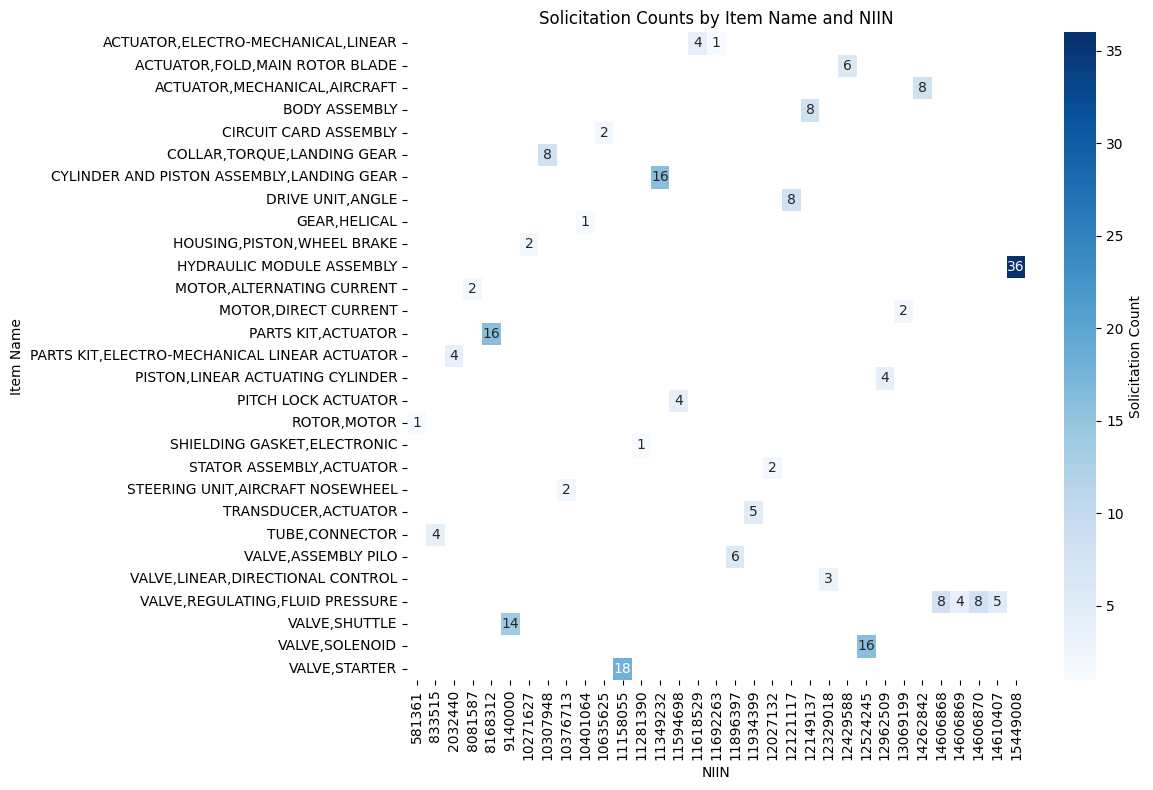

In [44]:
#Connecting Items, NIINs, and Vendor Codes
government_solicitations_df = pd.read_sql_query("SELECT * FROM GovernmentSolicitations", conn)
mcrl_df = pd.read_sql_query("SELECT * FROM MCRLMasterCrossReferenceList", conn)
merged_df = pd.merge(government_solicitations_df, mcrl_df, on='NIIN', how='inner')
summary = merged_df.groupby(['Item_Name', 'NIIN']).size().reset_index(name='Solicitation_Count')
pivot_table = summary.pivot(index='Item_Name', columns='NIIN', values='Solicitation_Count')

# Visualize data as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="Blues", cbar_kws={'label': 'Solicitation Count'})
plt.title("Solicitation Counts by Item Name and NIIN")
plt.xlabel("NIIN")
plt.ylabel("Item Name")
plt.tight_layout()
plt.show()



In [45]:

# Utilizing the heatmap, I wanted to figure out which items are being solicited the most by the government and who makes those items
top_solicitations = vendor_sales[vendor_sales['NIIN'] == 15449008]
print(top_solicitations)
#I used a public cage to company database search to find the name of the two companies:
# Cage 70236 : TACTAIR FLUID CONTROLS, INC
# Cage 97499 : BELL TEXTRON INC.	

     CAGE                  Item_Name      NIIN  Sales_Count
40  70236  HYDRAULIC MODULE ASSEMBLY  15449008           24
83  97499  HYDRAULIC MODULE ASSEMBLY  15449008           12


In [46]:
#Part Availability: Finding items with multiple vendors (Analyzing Competitiveness)
mcrl_df = pd.read_sql_query("SELECT NIIN, CAGE FROM MCRLMasterCrossReferenceList", conn)
part_availability = mcrl_df.groupby('NIIN')['CAGE'].nunique().reset_index(name='Vendor_Count')
part_availability['Supplier_Type'] = part_availability['Vendor_Count'].apply(lambda x: 'single' if x == 1 else 'multiple')
print(part_availability.head())
sorted_part_availability = part_availability.sort_values(by = 'Vendor_Count', ascending=False)
print(sorted_part_availability.head())


    NIIN  Vendor_Count Supplier_Type
0  19673             2      multiple
1  30238             2      multiple
2  30395             2      multiple
3  30955             2      multiple
4  35273             2      multiple
         NIIN  Vendor_Count Supplier_Type
2097  5543304            94      multiple
2101  5545396            87      multiple
2106  5545962            61      multiple
771   1981050            58      multiple
662   1558418            51      multiple


In [47]:
vendor_data_query = """
SELECT gs.NIIN, m.CAGE, COUNT(gs.Solicitation_Number) AS Solicitation_Frequency
FROM GovernmentSolicitations AS gs
INNER JOIN MCRLMasterCrossReferenceList AS m ON gs.NIIN = m.NIIN
GROUP BY m.CAGE
"""
vendor_consistency = pd.read_sql_query(vendor_data_query, conn)
#Add a reliability metric based on solicitation frequency alone
vendor_consistency['Reliability_Score'] = vendor_consistency['Solicitation_Frequency']
print(vendor_consistency.head())

       NIIN   CAGE  Solicitation_Frequency  Reliability_Score
0  11934399  00288                       2                  2
1  14610407  02769                       1                  1
2  12524245  03950                       4                  4
3  14262842  05624                       2                  2
4   9140000  06177                       2                  2


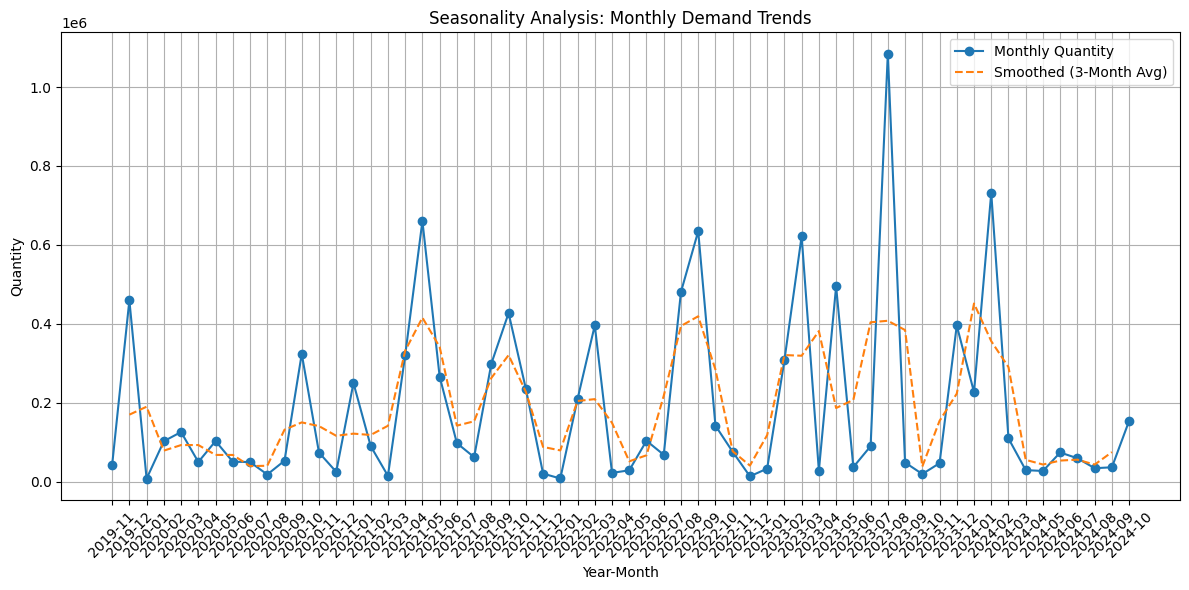

In [48]:
#Demand Seasonality Anlysis with Rolling Averages
query = """
SELECT ph.NIIN, ph.Date, ph.Quantity, ph.Price, mc.Item_Name AS Item_Description
FROM ProcurementHistory ph
LEFT JOIN MCRLMasterCrossReferenceList mc
ON ph.NIIN = mc.NIIN
"""
df = pd.read_sql(query, conn)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df = df.dropna(subset=['Quantity'])
df['YearMonth'] = df['Date'].dt.to_period('M')
monthly_trends = df.groupby(['YearMonth']).agg(total_quantity=('Quantity', 'sum')).reset_index()
#Trend, 3 month window
monthly_trends['Smoothed_Quantity'] = monthly_trends['total_quantity'].rolling(window=3, center=True).mean()

# Plot seasonality trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_trends['YearMonth'].astype(str), monthly_trends['total_quantity'], label='Monthly Quantity', marker='o')
plt.plot(monthly_trends['YearMonth'].astype(str), monthly_trends['Smoothed_Quantity'], label='Smoothed (3-Month Avg)', linestyle='--')
plt.xticks(rotation=45)
plt.title("Seasonality Analysis: Monthly Demand Trends")
plt.xlabel("Year-Month")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Outliers in Quantity:
          NIIN       Date  Quantity   Price      Item_Description YearMonth
0      9231055 2020-05-26         0   $0.00            DISK,VALVE   2020-05
1      9231055 2020-05-26         0   $0.00            DISK,VALVE   2020-05
1522   9435137 2020-04-30         0   $0.00          SEAT,BEARING   2020-04
1523   9435137 2020-04-30         0   $0.00          SEAT,BEARING   2020-04
1524   9435137 2020-04-30         0   $0.00          SEAT,BEARING   2020-04
...        ...        ...       ...     ...                   ...       ...
78219  2034097 2022-08-14      1217  $13.95  BEARING,BALL,ANNULAR   2022-08
78220  2034097 2022-08-14      1217  $13.95  BEARING,BALL,ANNULAR   2022-08
78221  2034097 2022-08-14      1217  $13.95  BEARING,BALL,ANNULAR   2022-08
78222  2034097 2022-08-14      1217  $13.95  BEARING,BALL,ANNULAR   2022-08
78223  2034097 2022-08-14      1217  $13.95  BEARING,BALL,ANNULAR   2022-08

[4077 rows x 6 columns]


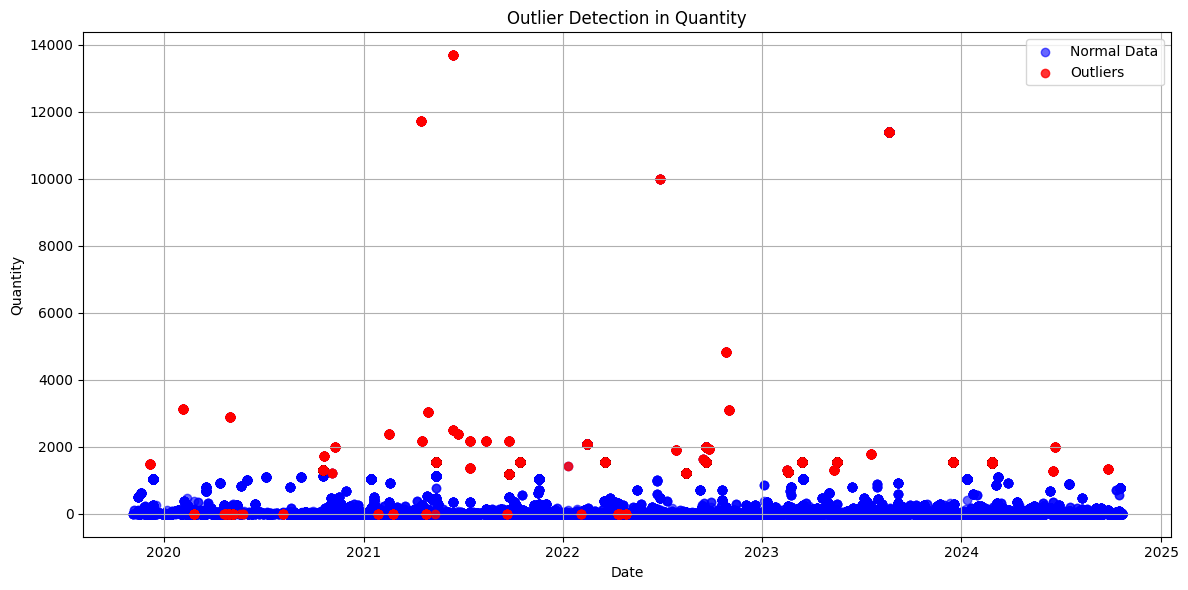

In [49]:
#Outlier Detection: Adjusted using both prodcurement history and master cross reference sheet
q_low = df['Quantity'].quantile(0.05)
q_high = df['Quantity'].quantile(0.95)
outliers = df[(df['Quantity'] < q_low) | (df['Quantity'] > q_high)]
print("Outliers in Quantity:")
print(outliers)
plt.figure(figsize=(12, 6))
plt.scatter(df['Date'], df['Quantity'], color='blue', label='Normal Data', alpha=0.6)
plt.scatter(outliers['Date'], outliers['Quantity'], color='red', label='Outliers', alpha=0.8)
plt.title("Outlier Detection in Quantity")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Product Diversity Over the Years:
   Year  Unique_Products
0  2019               76
1  2020              363
2  2021              326
3  2022              346
4  2023              430
5  2024              374


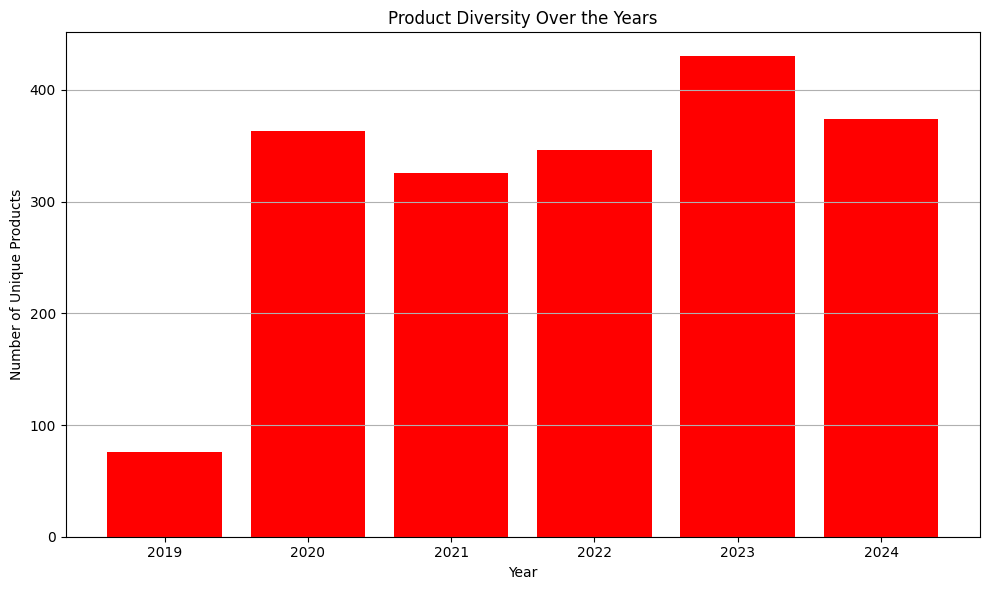

In [50]:
#Product Diversity analysis
df['Year'] = df['Date'].dt.year
product_diversity = df.groupby('Year')['NIIN'].nunique().reset_index(name='Unique_Products')

# Output product diversity
print("Product Diversity Over the Years:")
print(product_diversity)

# Plot product diversity
plt.figure(figsize=(10, 6))
plt.bar(product_diversity['Year'], product_diversity['Unique_Products'], color='red')
plt.title("Product Diversity Over the Years")
plt.xlabel("Year")
plt.ylabel("Number of Unique Products")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

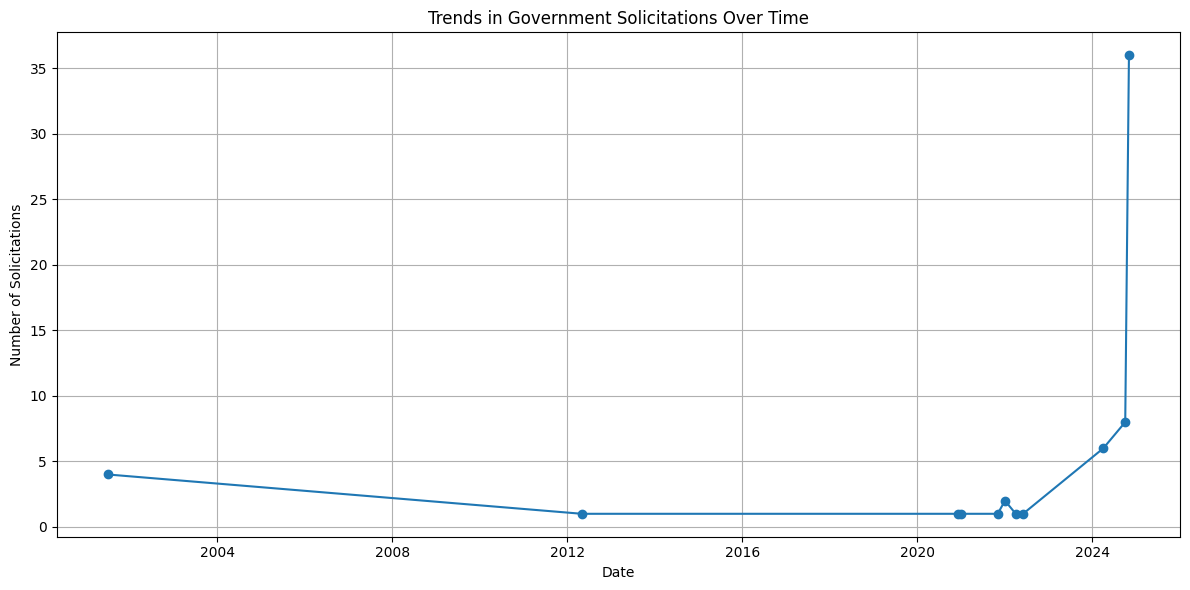

In [51]:

#Trends in government solicitations over time
solicitation_trends_query = """
SELECT Open_Date, COUNT(Solicitation_Number) AS Solicitation_Count
FROM GovernmentSolicitations
GROUP BY Open_Date
"""

# Execute SQL query
solicitation_trends = pd.read_sql_query(solicitation_trends_query, conn)

try:
    solicitation_trends['Open_Date'] = pd.to_datetime(solicitation_trends['Open_Date'], format='%m/%d/%Y')
except:
    solicitation_trends['Open_Date'] = pd.to_datetime(solicitation_trends['Open_Date'], errors='coerce')
solicitation_trends = solicitation_trends.dropna(subset=['Open_Date'])
solicitation_trends['YearMonth'] = solicitation_trends['Open_Date'].dt.to_period('M')
monthly_trends = solicitation_trends.groupby('YearMonth').agg(
    Monthly_Solicitation_Count=('Solicitation_Count', 'sum')
).reset_index()
monthly_trends['YearMonth'] = monthly_trends['YearMonth'].dt.to_timestamp()

# Plot trends in government solicitations
plt.figure(figsize=(12, 6))
plt.plot(monthly_trends['YearMonth'], monthly_trends['Monthly_Solicitation_Count'], marker='o')
plt.title("Trends in Government Solicitations Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Solicitations")
plt.grid(True)
plt.tight_layout()
plt.show()

Monthly Aggregated Data (Time Removed):
           YearMonth  total_quantity
Date                                
2019-11-01   2019-11            2611
2019-12-01   2019-12            7795
2020-01-01   2020-01            1082
2020-02-01   2020-02            6529
2020-03-01   2020-03            4664
ADF Statistic: -7.215684332378916
p-value: 2.1763218716061596e-10
Data is stationary. Proceeding without differencing...
Training ARIMA model...


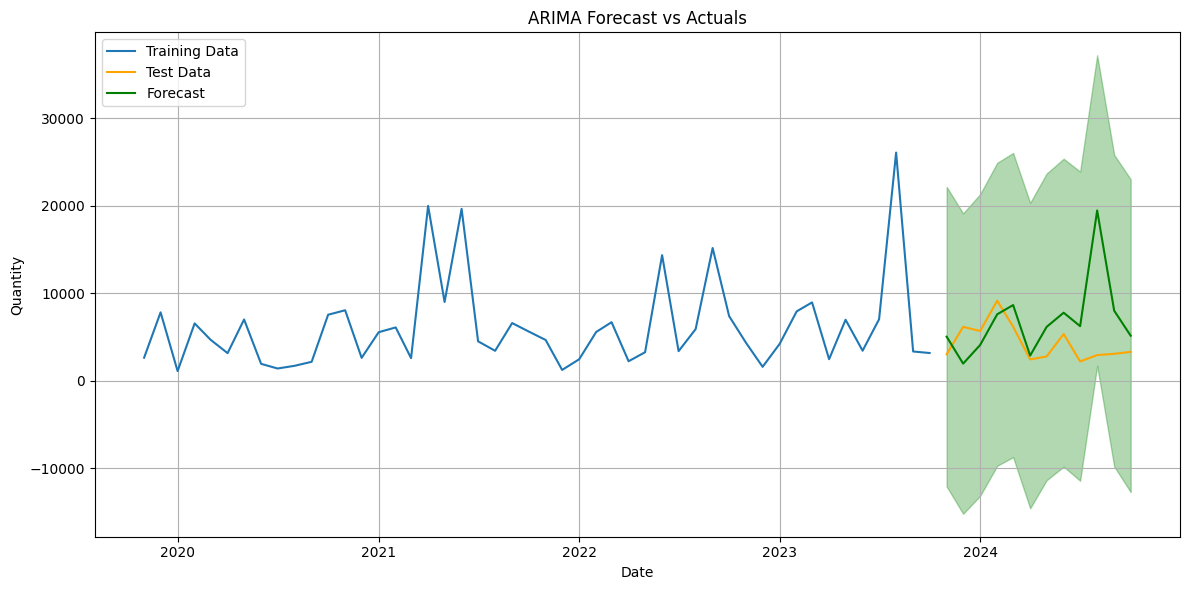

Root Mean Squared Error (RMSE): 5532.471441615553


In [ ]:

query = """
SELECT 
    Date,
    SUM(Quantity) AS total_quantity
FROM ProcurementHistory
WHERE Date IS NOT NULL
GROUP BY Date;
"""
monthly_data = pd.read_sql_query(query, conn)

monthly_data['Date'] = pd.to_datetime(monthly_data['Date']).dt.date

monthly_data['YearMonth'] = pd.to_datetime(monthly_data['Date']).dt.to_period('M')
monthly_data = monthly_data.groupby('YearMonth').agg(total_quantity=('total_quantity', 'sum')).reset_index()

monthly_data['Date'] = monthly_data['YearMonth'].dt.to_timestamp()
monthly_data.set_index('Date', inplace=True)

print("Monthly Aggregated Data (Time Removed):")
print(monthly_data.head())
adf_result = adfuller(monthly_data['total_quantity'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# Differencing
if adf_result[1] > 0.05:
    monthly_data['diff_quantity'] = monthly_data['total_quantity'].diff().dropna()
    train_data = monthly_data['diff_quantity'].iloc[:-12]
    test_data = monthly_data['diff_quantity'].iloc[-12:]
else:
    train_data = monthly_data['total_quantity'].iloc[:-12]
    test_data = monthly_data['total_quantity'].iloc[-12:]

# Train-test split
train = train_data
test = test_data

# ARIMA Model Training
print("Training ARIMA model...")
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
model_fit = model.fit(disp=False)

# Forecasting
forecast = model_fit.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='green')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
plt.legend()
plt.title("ARIMA Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.grid()
plt.tight_layout()
plt.show()

# Evaluate Forecast
rmse = np.sqrt(mean_squared_error(test, forecast.predicted_mean))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Random Forest RMSE: 1196.1997595440878


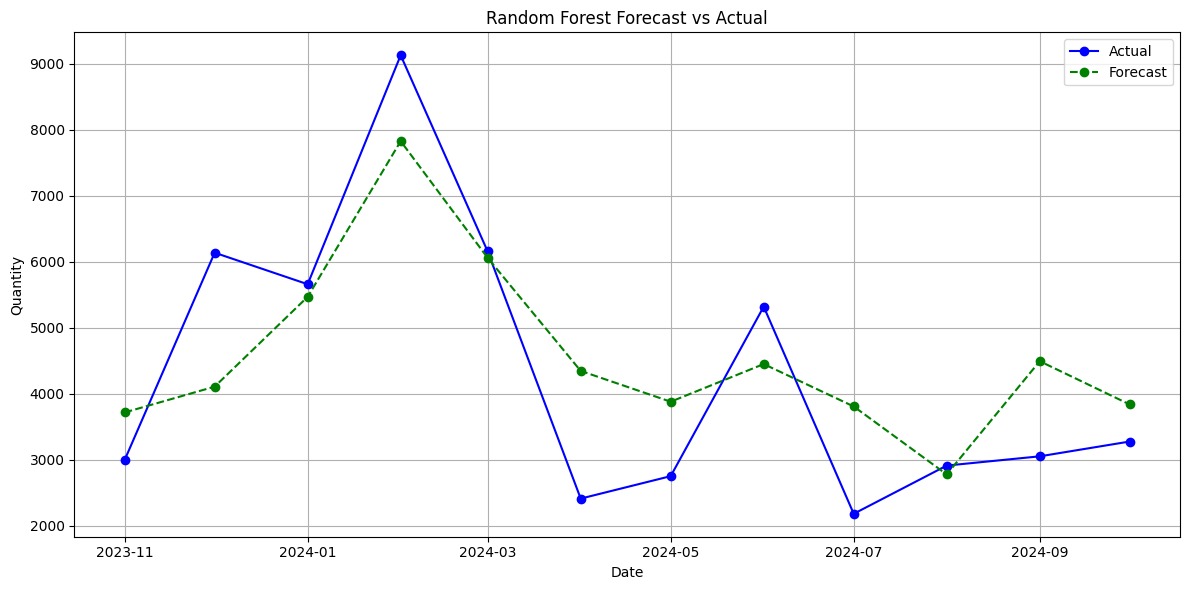

In [56]:

monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.month
monthly_data['Lag_1'] = monthly_data['total_quantity'].shift(1)
monthly_data['Lag_2'] = monthly_data['total_quantity'].shift(2)
monthly_data['Rolling_Mean_3'] = monthly_data['total_quantity'].rolling(window=3).mean()

# Drop rows with NaN values introduced by lag and rolling mean
monthly_data = monthly_data.dropna()

# Define features and target
features = ['Year', 'Month', 'Lag_1', 'Lag_2', 'Rolling_Mean_3']
target = 'total_quantity'

X = monthly_data[features]
y = monthly_data[target]

# Train-test split (last 12 months as test set)
train_size = len(X) - 12
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=SEED)
rf_model.fit(X_train, y_train)

#predictions
y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Random Forest RMSE: {rmse}")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o')
plt.plot(y_test.index, y_pred, label='Forecast', color='green', linestyle='--', marker='o')
plt.title("Random Forest Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

XGBoost RMSE: 1093.7321998551565


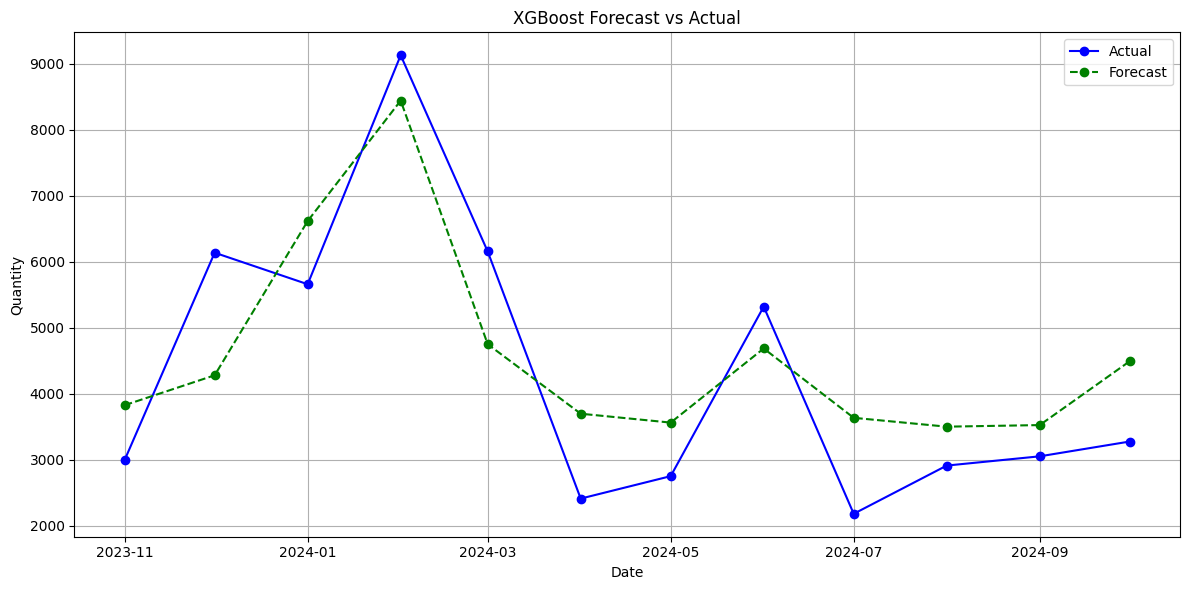

In [ ]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.month
monthly_data['Lag_1'] = monthly_data['total_quantity'].shift(1)
monthly_data['Lag_2'] = monthly_data['total_quantity'].shift(2)
monthly_data['Rolling_Mean_3'] = monthly_data['total_quantity'].rolling(window=3).mean()

monthly_data = monthly_data.dropna()

features = ['Year', 'Month', 'Lag_1', 'Lag_2', 'Rolling_Mean_3']
target = 'total_quantity'

X = monthly_data[features]
y = monthly_data[target]

# Train-test split (last 12 months)
train_size = len(X) - 12
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=SEED)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"XGBoost RMSE: {rmse}")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o')
plt.plot(y_test.index, y_pred, label='Forecast', color='green', linestyle='--', marker='o')
plt.title("XGBoost Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Stacked Model RMSE: 857.8782665258537


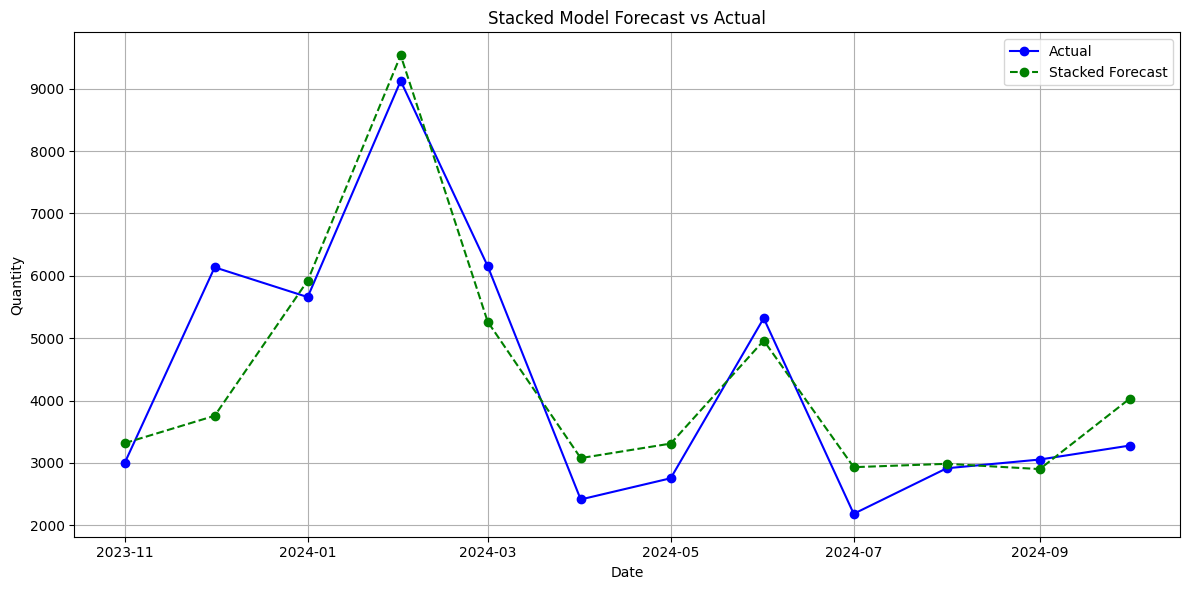

In [ ]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.month
monthly_data['Lag_1'] = monthly_data['total_quantity'].shift(1)
monthly_data['Lag_2'] = monthly_data['total_quantity'].shift(2)
monthly_data['Rolling_Mean_3'] = monthly_data['total_quantity'].rolling(window=3).mean()

monthly_data = monthly_data.dropna()

features = ['Year', 'Month', 'Lag_1', 'Lag_2', 'Rolling_Mean_3']
target = 'total_quantity'

X = monthly_data[features]
y = monthly_data[target]

train_size = len(X) - 12
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train
rf_model = RandomForestRegressor(n_estimators=100, random_state=SEED)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=SEED)

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Generate predictions 
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Combine predictions 
stacked_X = np.column_stack((rf_pred, xgb_pred))

# Train meta model
meta_model = LinearRegression()
meta_model.fit(stacked_X, y_test)

# Final predictions
stacked_predictions = meta_model.predict(stacked_X)

# Evaluate stacked model
rmse = np.sqrt(mean_squared_error(y_test, stacked_predictions))
print(f"Stacked Model RMSE: {rmse}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o')
plt.plot(y_test.index, stacked_predictions, label='Stacked Forecast', color='green', linestyle='--', marker='o')
plt.title("Stacked Model Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:

query = """ 
SELECT 
    p.NIIN,
    p.Date,
    SUM(p.Quantity) AS total_quantity
FROM ProcurementHistory p
GROUP BY p.NIIN, p.Date
ORDER BY p.NIIN, p.Date;
"""


data = pd.read_sql_query(query, conn)
data['Date'] = data['Date'].str.split(' ').str[0]  
data['Date'] = pd.to_datetime(data['Date'], errors='coerce') 
data = data.dropna(subset=['Date'])  
data = data.sort_values(by=['NIIN', 'Date'])  

data = data.groupby('NIIN', group_keys=False).apply(
    lambda x: x.set_index('Date').resample('MS').sum().fillna(0)  
).reset_index()

data = data.groupby('NIIN').filter(lambda x: len(x) >= 12)


for niin_id in data['NIIN'].unique():
    niin_data = data[data['NIIN'] == niin_id].set_index('Date')['total_quantity']
    
    if niin_data.nunique() <= 1:
        continue

    result = adfuller(niin_data)
    print(f"ADF Statistic for NIIN {niin_id}: {result[0]}")
    print(f"p-value: {result[1]}")
    
    if result[1] > 0.05:
        niin_data_diff = niin_data.diff().dropna()
    else:
        niin_data_diff = niin_data


ADF Statistic for NIIN 4370022: -3.979366719205921
p-value: 0.0015224915144816434
ADF Statistic for NIIN 5545237: -2.648943743028486
p-value: 0.08329750436804156
ADF Statistic for NIIN 7205810: -0.7014476890152574
p-value: 0.8463741973500403
ADF Statistic for NIIN 9231067: -8.38572125560369
p-value: 2.441553495014693e-13
ADF Statistic for NIIN 9232575: 0.02416485611415141
p-value: 0.9604854594398295
ADF Statistic for NIIN 9808475: -5.327852978267635
p-value: 4.793220869648445e-06
ADF Statistic for NIIN 10334396: -1.6556401463624866
p-value: 0.4541006066055127
ADF Statistic for NIIN 12403580: -13.050944089693779
p-value: 2.142712008710398e-24
ADF Statistic for NIIN 13100220: -0.9477432511462253
p-value: 0.771843769408193


In [ ]:
# Check if the series is constant or invalid
if niin_data.nunique() <= 1:
    print("The series is constant or has insufficient variability. Skipping ADF test.")
else:
    # Perform ADF test
    result = adfuller(niin_data)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("The series is non-stationary. Differencing is required.")
        niin_data_diff = niin_data.diff().dropna()
    else:
        print("The series is stationary.")
        niin_data_diff = niin_data



ADF Statistic: -0.9477432511462253
p-value: 0.771843769408193
The series is non-stationary. Differencing is required.


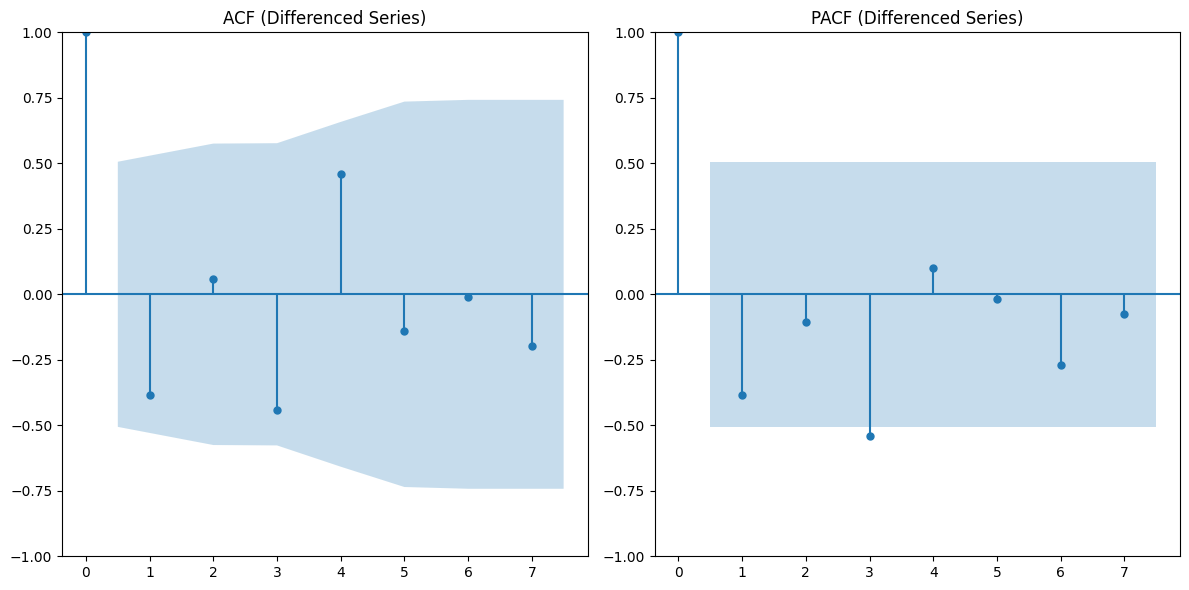

In [ ]:
# differencing
niin_data_diff = niin_data.diff().dropna()

if len(niin_data_diff) < 3:
else:
    max_lags = min(20, len(niin_data_diff) // 2)

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(niin_data_diff, lags=max_lags, ax=plt.gca())
    plt.title("ACF (Differenced Series)")

    plt.subplot(122)
    plot_pacf(niin_data_diff, lags=max_lags, ax=plt.gca(), method='ywm')
    plt.title("PACF (Differenced Series)")

    plt.tight_layout()
    plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model
p, d, q = 1, 1, 4  
arima_model = ARIMA(niin_data, order=(p, d, q))


arima_result = arima_model.fit()

# summary
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:         total_quantity   No. Observations:                   16
Model:                 ARIMA(1, 1, 4)   Log Likelihood                 -68.353
Date:                Wed, 11 Dec 2024   AIC                            148.706
Time:                        17:36:17   BIC                            152.954
Sample:                             0   HQIC                           148.661
                                 - 16                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4868      1.108      0.439      0.660      -1.684       2.658
ma.L1         -0.8521   1594.871     -0.001      1.000   -3126.742    3125.038
ma.L2          0.2209    188.982      0.001      0.9

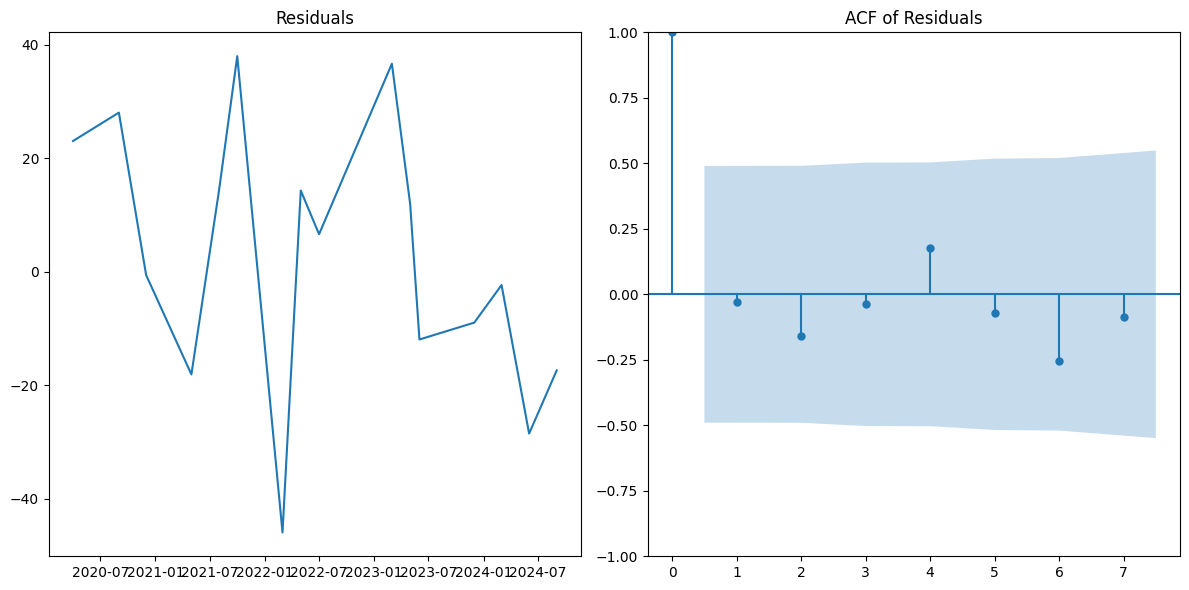

In [ ]:
# Plot residuals
residuals = arima_result.resid

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title("Residuals")

plt.subplot(122)
plot_acf(residuals, lags=7, ax=plt.gca())
plt.title("ACF of Residuals")

plt.tight_layout()
plt.show()


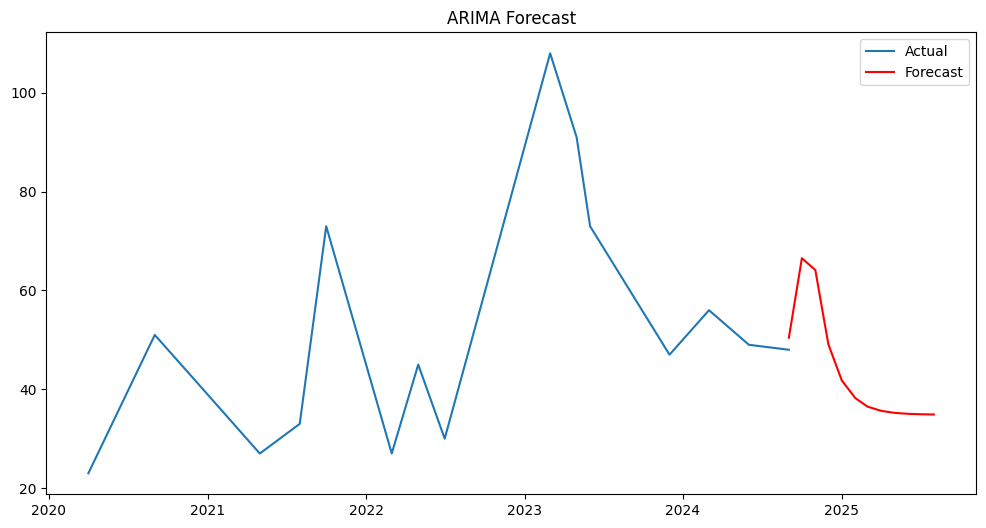

RMSE: 23.02015923172528
MAPE: 0.4159687872686773


In [ ]:
# Forecast the next 12 periods
forecast_steps = 12
forecast = arima_result.forecast(steps=forecast_steps)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(niin_data.index, niin_data, label='Actual')
plt.plot(pd.date_range(niin_data.index[-1], periods=forecast_steps, freq='MS'), forecast, label='Forecast', color='red')
plt.title("ARIMA Forecast")
plt.legend()
plt.show()

# in-sample predictions
predictions = arima_result.fittedvalues

# evaluation metrics
rmse = np.sqrt(mean_squared_error(niin_data[1:], predictions[1:]))
mape = mean_absolute_percentage_error(niin_data[1:], predictions[1:])

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")


In [ ]:
conn.close()